# Lecture 4: Structure your model

###  Phase 1: Assemble graph
1. Define placeholders for input and output
2. Define the weights
3. Define the inference model
4. Define loss function
5. Define optimizer

# Word2vec example: skipgram

## with embeddings visualization
**Note: Negative Sampling is a simplified version of Noise Contrastive Estimation. And NCE guarantees approximation to softmax, Negative Sampling doesn’t**

http://papers.nips.cc/paper/5165-learning-word-embeddings-efficiently-with-noise-contrastive-estimation.pdf

In [1]:
""" word2vec with NCE loss 
and code to visualize the embeddings on TensorBoard
"""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
from tensorflow.contrib.tensorboard.plugins import projector
import tensorflow as tf
import time
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

from process_data import process_data
from util import newlogname, get_log_search

class Config(object):
    """Holds model hyperparams and data information.
    The config class is used to store various hyperparameters and dataset
    information parameters. Model objects are passed a Config() object at
    instantiation.
    """
    def __init__(self,
                 vocab_size=50000,
                 batch_size=128,
                 embed_size=128,
                 skip_window=1,
                 num_sampled=64,
                 lr=1.0,
                 num_train_steps=100000,
                 weights_fld = 'processed/',
                 skip_step=2000):
        self.vocab_size = vocab_size
        self.batch_size = batch_size
        self.embed_size = embed_size
        self.skip_window = skip_window
        self.num_sampled = num_sampled
        self.lr = lr
        self.num_train_steps = num_train_steps
        self.weights_fld = weights_fld
        self.skip_step = skip_step
        
class SkipGramModel:
    """ Build the graph for word2vec model """
    def __init__(self, config):
        self.name = newlogname()
        self.config = config
        self.vocab_size = self.config.vocab_size
        self.embed_size = self.config.embed_size
        self.batch_size = self.config.batch_size
        self.num_sampled = self.config.num_sampled
        self.lr = self.config.lr
        self.build_graph()

    def _create_placeholders(self):
        """ Step 1: define the placeholders for input and output """
        with tf.name_scope("data"):
            self.center_words = tf.placeholder(tf.int32, shape=[self.batch_size], name='center_words')
            self.target_words = tf.placeholder(tf.int32, shape=[self.batch_size, 1], name='target_words')

    def _create_embedding(self):
        """ Step 2: define weights. In word2vec, it's actually the weights that we care about """
        # Assemble this part of the graph on the CPU. You can change it to GPU if you have GPU
        with tf.device('/cpu:0'):
            with tf.name_scope("embed"):
                emshape = (self.vocab_size, self.embed_size)
                eminit = tf.random_uniform(shape=emshape, minval=-1, maxval=1)
                self.embed_matrix = tf.get_variable("embed_matrix",
                                                    dtype=tf.float32,
                                                    initializer=eminit)

    def _create_loss(self):
        """ Step 3 + 4: define the model + the loss function """
        with tf.device('/cpu:0'):
            
            with tf.name_scope("nce"):
                Wshape = (self.vocab_size, self.embed_size)
                bshape = (self.vocab_size)
                std = 1.0/(self.config.embed_size ** 0.5)
                Winit = tf.truncated_normal(shape=Wshape,
                                            stddev=std)
                binit = tf.zeros(bshape)
                
                self.nce_weight = tf.get_variable("nce_weight", dtype=tf.float32, initializer=Winit)
                self.nce_bias = tf.get_variable("nce_bias", dtype=tf.float32, initializer=binit)

            
            with tf.name_scope("loss"):
                # Step 3: define the inference
                embed = tf.nn.embedding_lookup(self.embed_matrix, self.center_words, name='embed')

                # Step 4: define loss function
                self.loss = tf.reduce_mean(tf.nn.nce_loss(weights=self.nce_weight, 
                                                          biases=self.nce_bias, 
                                                          labels=self.target_words, 
                                                          inputs=embed, 
                                                          num_sampled=self.num_sampled, 
                                                          num_classes=self.vocab_size), name='loss')
    def _create_optimizer(self):
        """ Step 5: define optimizer """
        with tf.device('/cpu:0'):
            with tf.name_scope("train"):
                opt = tf.train.GradientDescentOptimizer(self.lr)
                self.optimizer = opt.minimize(self.loss,
                                              global_step=self.global_step)


    def _create_summaries(self):
        with tf.name_scope("summaries"):
            tf.summary.scalar("loss", self.loss)
            #tf.summary.histogram("histogram_loss", self.loss)
            #tf.summary.histogram("histogram_nce_weight", self.nce_weight)
            #tf.summary.histogram("histogram_nce_bias",self.nce_bias)
            # because you have several summaries, we should merge them all
            # into one op to make it easier to manage
            self.summary_op = tf.summary.merge_all()

    def build_graph(self):
        """ Build the graph for our model """
        self.graph = tf.Graph()
        with self.graph.as_default():
            self.global_step = tf.Variable(0, dtype=tf.int32, trainable=False, name='global_step')
            self.saver = tf.train.Saver() 
            self._create_placeholders()
            self._create_embedding()
            self._create_loss()
            self._create_optimizer()
            self._create_summaries()

##  Phase 2: Compute


Which is basically training your model. There are a few steps:
1. Initialize all model variables for the first time.
2. Feed in the training data. Might involve randomizing the order of data samples.
3. Execute the inference model on the training data, so it calculates for each training inputexample the output with the current model parameters.
4. Compute the cost
5. Adjust the model parameters to minimize/maximize the cost depending on the model.

In [6]:
def train_model(model,
                batch_gen,
                config,
                save=True,
                search_path=None,
                visualization=False):
    
    if search_path is None:
        logdir = model.name
    else:
        assert type(search_path) == str
        logdir = search_path
    skip_step = config.skip_step
    print("\n&&&&&  logdir={}  &&&&&".format(logdir))
    num_train_steps = config.num_train_steps 
    weights_fld = config.weights_fld 
    saver = model.saver # defaults to saving all variables - in this case embed_matrix, nce_weight, nce_bias
    initial_time = time.time()
    initial_step = 0
    with tf.Session(graph=model.graph) as sess:
        sess.run(tf.global_variables_initializer())
        if save:
            ckpt = tf.train.get_checkpoint_state(os.path.dirname('checkpoints/checkpoint'))
            # if that checkpoint exists, restore from checkpoint
            if ckpt and ckpt.model_checkpoint_path:
                saver.restore(sess, ckpt.model_checkpoint_path)

        total_loss = 0.0 # we use this to calculate late average loss in the last SKIP_STEP steps
        writer = tf.summary.FileWriter(logdir, sess.graph)
        initial_step = sess.run(model.global_step)
        for index in range(initial_step, initial_step + num_train_steps):
            centers, targets = batch_gen.__next__()
            feed_dict={model.center_words: centers, model.target_words: targets}
            loss_batch, _, summary = sess.run([model.loss, model.optimizer, model.summary_op], 
                                              feed_dict=feed_dict)
            writer.add_summary(summary, global_step=index)
            writer.flush()
            total_loss += loss_batch
            last_loss = loss_batch 

            if (index + 1) % skip_step == 0:
                print('\nAverage loss at step {}: {:5.1f}'.format(index, total_loss / skip_step))
                total_loss = 0.0
                if save:
                    saver.save(sess,'checkpoints/skip-gram', index)  
        if visualization:
            final_embed_matrix = sess.run(model.embed_matrix)
        
            # it has to variable. constants don't work here. you can't reuse model.embed_matrix
            embedding_var = tf.Variable(final_embed_matrix[:1000], name='embedding')
            sess.run(embedding_var.initializer)

            emconfig = projector.ProjectorConfig()
            summary_writer = tf.summary.FileWriter('processed')

            # add embedding to the config file
            embedding = emconfig.embeddings.add()
            embedding.tensor_name = embedding_var.name
        
            # link this tensor to its metadata file, in this case the first 500 words of vocab
            embedding.metadata_path = 'processed/vocab_1000.tsv'

            # saves a configuration file that TensorBoard will read during startup.
            projector.visualize_embeddings(summary_writer, emconfig)
            saver_embed = tf.train.Saver([embedding_var])
            saver_embed.save(sess, 'processed/model3.ckpt', 1)
    duration = time.time() - initial_time
    return last_loss, duration 

**A basic training of this model**

In [12]:
basic_config = Config()
batch_gen = process_data(basic_config.vocab_size, basic_config.batch_size, basic_config.skip_window)
model = SkipGramModel(basic_config)
_, _ = train_model(model,batch_gen,basic_config,visualization=True)

Dataset ready

&&&&&  logdir=./graphs/08-03-2017_11-13-25  &&&&&

Average loss at step 13999: 113.7

Average loss at step 15999:  52.9

Average loss at step 17999:  32.8

Average loss at step 19999:  23.5

Average loss at step 21999:  17.9

Average loss at step 23999:  14.0

Average loss at step 25999:  11.9

Average loss at step 27999:  10.0

Average loss at step 29999:   8.5

Average loss at step 31999:   8.0

Average loss at step 33999:   7.0

Average loss at step 35999:   7.0

Average loss at step 37999:   6.7

Average loss at step 39999:   6.4

Average loss at step 41999:   6.0

Average loss at step 43999:   6.0

Average loss at step 45999:   5.7

Average loss at step 47999:   5.8

Average loss at step 49999:   5.5

Average loss at step 51999:   5.2

Average loss at step 53999:   5.4

Average loss at step 55999:   5.2

Average loss at step 57999:   5.2

Average loss at step 59999:   5.2

Average loss at step 61999:   5.0

Average loss at step 63999:   5.0

Average loss at step 659

In [14]:
! tensorboard --logdir=./graphs/08-03-2017_11-13-25 --port=8008

Starting TensorBoard b'41' on port 8008
(You can navigate to http://127.0.1.1:8008)
^CTraceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 11, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/tensorboard/tensorboard.py", line 151, in main
    tb_server.serve_forever()
  File "/usr/lib/python3.5/socketserver.py", line 232, in serve_forever
    ready = selector.select(poll_interval)
  File "/usr/lib/python3.5/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt



In [1]:
! tensorboard --logdir=./processed --port=8008

Starting TensorBoard b'41' on port 8008
(You can navigate to http://127.0.1.1:8008)
^CTraceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 11, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/tensorboard/tensorboard.py", line 151, in main
    tb_server.serve_forever()
  File "/usr/lib/python3.5/socketserver.py", line 232, in serve_forever
    ready = selector.select(poll_interval)
  File "/usr/lib/python3.5/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt



# Searching the best embedding size

Dataset ready

 (1 of 13)

&&&&&  logdir=./graphs/embed-size130  &&&&&

Average loss at step 1999: 113.7

Average loss at step 3999:  52.4

 (2 of 13)

&&&&&  logdir=./graphs/embed-size140  &&&&&

Average loss at step 1999: 113.7

Average loss at step 3999:  52.7

 (3 of 13)

&&&&&  logdir=./graphs/embed-size150  &&&&&

Average loss at step 1999: 114.0

Average loss at step 3999:  53.0

 (4 of 13)

&&&&&  logdir=./graphs/embed-size160  &&&&&

Average loss at step 1999: 114.6

Average loss at step 3999:  52.9

 (5 of 13)

&&&&&  logdir=./graphs/embed-size170  &&&&&

Average loss at step 1999: 113.8

Average loss at step 3999:  52.9

 (6 of 13)

&&&&&  logdir=./graphs/embed-size180  &&&&&

Average loss at step 1999: 113.5

Average loss at step 3999:  53.0

 (7 of 13)

&&&&&  logdir=./graphs/embed-size190  &&&&&

Average loss at step 1999: 113.9

Average loss at step 3999:  53.2

 (8 of 13)

&&&&&  logdir=./graphs/embed-size200  &&&&&

Average loss at step 1999: 114.1

Average loss at ste

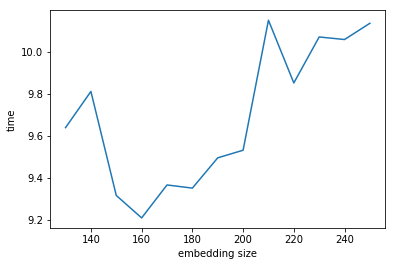

In [32]:

EMBEDDINGS = np.array(range(13,26)) *10
number_of_exp = len(EMBEDDINGS)
results = []
times = []
basic_config = Config()
batch_gen = process_data(basic_config.vocab_size, basic_config.batch_size, basic_config.skip_window)


for i, em in enumerate(EMBEDDINGS):
    print("\n ({0} of {1})".format(i+1, number_of_exp))
    config = Config(embed_size= em, num_train_steps=4000)
    model = SkipGramModel(config)
    loss, duration = train_model(model,
                                 batch_gen,
                                 config,
                                 save=False,
                                 search_path=get_log_search('embed-size',em))
    
    
    
    results.append(loss)
    times.append(duration)

best_result = min(list(zip(results, EMBEDDINGS, times)))
result_string = """In an experiment with {0} embeddings sizes
the best size is {1} with loss = {2}. Using
this size the training will take {3} seconds""".format(number_of_exp,
                                                       best_result[1],
                                                       best_result[0],
                                                       best_result[2])

print(result_string)

# Make a plot of batch vs time
plt.plot(EMBEDDINGS, times)
plt.xlabel("embedding size")
plt.ylabel("time")
plt.show()
#plt.savefig("embeddings_time.png")

In [33]:
# ! tensorboard --logdir=./graphs --port=8008

Starting TensorBoard b'41' on port 8008
(You can navigate to http://127.0.1.1:8008)
^C
Traceback (most recent call last):
  File "/home/felsal/workenv/bin/tensorboard", line 11, in <module>
    sys.exit(main())
  File "/home/felsal/workenv/lib/python3.5/site-packages/tensorflow/tensorboard/tensorboard.py", line 151, in main
    tb_server.serve_forever()
  File "/usr/lib/python3.5/socketserver.py", line 232, in serve_forever
    ready = selector.select(poll_interval)
  File "/usr/lib/python3.5/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt


# Searching the best skip window


 (1 of 2)
Dataset ready

&&&&&  logdir=./graphs/skip-window1  &&&&&

Average loss at step 1999: 113.9

Average loss at step 3999:  52.6

 (2 of 2)
Dataset ready

&&&&&  logdir=./graphs/skip-window27  &&&&&

Average loss at step 1999: 134.5

Average loss at step 3999: 101.0

In an experiment with 2 skip windows
the best skip size is 1 with loss = 74.81986999511719. Using
this size the training will take 9.723862171173096 seconds


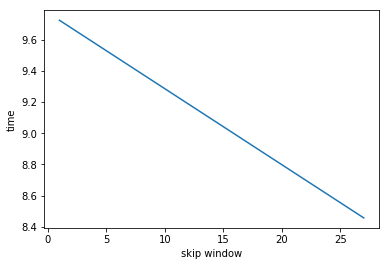

In [39]:

SKIP = [1,27]
number_of_exp = len(SKIP)
results = []
times = []

for i, ski in enumerate(SKIP):
    print("\n ({0} of {1})".format(i+1, number_of_exp))
    config = Config(skip_window= ski, num_train_steps=4000)
    model = SkipGramModel(config)
    batch_gen = process_data(config.vocab_size, config.batch_size, config.skip_window)
    loss, duration = train_model(model,
                                 batch_gen,
                                 config,
                                 save=False,
                                 search_path=get_log_search('skip-window',ski))
    
    
    
    results.append(loss)
    times.append(duration)

best_result = min(list(zip(results, SKIP, times)))
result_string = """\nIn an experiment with {0} skip windows
the best skip size is {1} with loss = {2}. Using
this size the training will take {3} seconds""".format(number_of_exp,
                                                       best_result[1],
                                                       best_result[0],
                                                       best_result[2])

print(result_string)

# Make a plot of batch vs time
plt.plot(SKIP, times)
plt.xlabel("skip window")
plt.ylabel("time")
plt.show()
#plt.savefig("skip_time.png")

In [40]:
# ! tensorboard --logdir=./graphs --port=8008

Starting TensorBoard b'41' on port 8008
(You can navigate to http://127.0.1.1:8008)
^C
Traceback (most recent call last):
  File "/home/felsal/workenv/bin/tensorboard", line 11, in <module>
    sys.exit(main())
  File "/home/felsal/workenv/lib/python3.5/site-packages/tensorflow/tensorboard/tensorboard.py", line 151, in main
    tb_server.serve_forever()
  File "/usr/lib/python3.5/socketserver.py", line 232, in serve_forever
    ready = selector.select(poll_interval)
  File "/usr/lib/python3.5/selectors.py", line 376, in select
    fd_event_list = self._poll.poll(timeout)
KeyboardInterrupt
